Briefly, our goal here is to model the association of life expectancy, as measured by the CDC, with several features of the built environment in each census tract in the city of Saint Louis, Missouri. We begin by reading in the data.

In [102]:
url = 'https://github.com/patrickstuchlik/cap1/raw/master/elastic2.csv'
import pandas as pd
df = pd.read_csv(url)
#df.head()
df2 = df.set_index('GEOID')
df2.head()

,land_perc,food1,food2,life,mw,cg,metrolink,tract_area,bike_len,bike_cnt,park1,park2,park1ratio,park2ratio,walk,unins
GEOID,,,,,,,,,,,,,,,,
29510106400,1.000000,0.000000,0.000000,69.9,1,0,0,1106529.051,855.237401,2,0.000,0.000,0.000000,0.000000,14.041750,27.0
29510125600,0.805083,0.000000,0.000000,73.2,3,0,4,2582190.793,12671.559820,25,39157.102,39157.102,0.015164,0.015164,18.777667,6.7
29510125700,0.857948,0.000331,0.000261,72.0,0,2,0,1486619.951,2922.391749,8,25647.334,25647.334,0.017252,0.017252,16.444667,18.2
29510123300,1.000000,0.453672,0.175716,76.2,0,0,0,918019.537,2305.878671,8,1650.961,1650.961,0.001798,0.001798,17.722000,8.7
29510124100,1.000000,0.000000,0.000000,67.8,9,1,0,1053137.860,1853.596805,6,0.000,0.000,0.000000,0.000000,13.833400,18.8


A quick word about each of our measured variables:





*   **'GEOID'** : the 11-digit FIPS code for each census tract
*   **'land_perc'** : the percent of each census tract that GIS calculated to be land (i.e. not water)
*   **'food1'** : a USDA calculated percentage of the total census tract with [low access to healthy food](https://www.ers.usda.gov/data-products/food-access-research-atlas/documentation/) within 1 mile
* **'food2'** : similarly, the percentage of the low-income population in the census tract with low access to healthy food within 1 mile
* **'life'** : [life expectancy](https://www.cdc.gov/nchs/nvss/usaleep/usaleep.html), in years, at birth for the census tract
* **'mw'** : number of [milkweed gardens](https://www.stlouis-mo.gov/monarchs/) in each census tract, planted to encourage the monarch butterfly population
* **'cg'** : number of [community gardens](http://www.gatewaygreening.org/resources/map-of-gardens/) in each census tract
* **'metrolink'** : number of [Metrolink](https://www.metrostlouis.org/developer-resources/) (light rail) stations in each census tract
* **'tract_area'** : area (units unclear due to GIS projection issues) of each census tract
* **'bike_len'** : total length of [bike lanes](https://www.stlouis-mo.gov/government/departments/street/streets-sidewalks-traffic/bicycling/bike-routes-and-maps.cfm) for each census tract
* **'bike_cnt'**: total segments of bike lanes for each census tract
* **'park1'** : total area of [parks](https://www.stlouis-mo.gov/data/parks.cfm) in each census tract (for similar reasons, units unclear)
* **'park1ratio'** : ratio of park1 / tract_area => the ratio of a census tract that is public parks
* **'park2' , 'park2ratio'** : a different (and inferior) polygon intersection tool was used in GIS to compute these park areas, in the same schema as park1 and park1ratio
* **'walk'** : National Walkability Index from the [EPA](https://www.epa.gov/smartgrowth/smart-location-mapping#walkability) Note that these scores are provided for census block groups, so these have been averaged over tracts here
* **'unins'**: percentage of the adult non-institutionalized population without health insurance in each census tract, from [Census American FactFinder](https://factfinder.census.gov/faces/nav/jsf/pages/index.xhtml)




In [0]:
X = df2[['food1','mw','cg','metrolink','bike_len','park1','walk','unins']]
y = df2['life']

A brief inspection of the distribution of life expectancy over the 106 census tracts in the city of St. Louis:

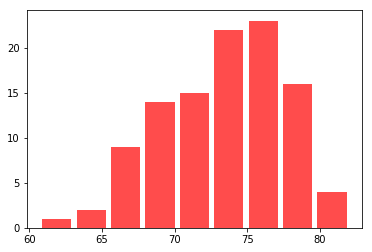

In [112]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=df2['life'], bins='auto', color='red', alpha=0.7, rwidth=0.85)

For the following analyses, we will focus on ~ eight features of the built environment: healthy food access, milkweed gardens, community gardens, Metrolink stations, bike lanes, park area, Walkability, and percent uninsured, a proxy for socioeconomic status relevant to this health outcome measure. 

The below cell will give you a scatter matrix of the relationships of all variables with each other, but it's not too useful.

In [0]:
pd.plotting.scatter_matrix(X)

The below cell will provide the scatter plots of each of these eight features with life expectancy.

In [0]:
cols = [col for col in X.columns]

for col in cols:
  df2.plot.scatter(x=col,y='life')

Now that we have our X and y data, we will split the data into test and training sets for machine learning algorithms.

In [0]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

We also imported a scaler to use in preprocessing in the event that our eventual model performs better with scaled data.

In [0]:
from sklearn.preprocessing import StandardScaler
scal = StandardScaler()
X_train_scaled = scal.fit_transform(X_train)
X_test_scaled = scal.fit_transform(X_test)

The next step was to test several models to have an idea which to pursue next. I tested a basic linear regression, along with lasso, elastic-net, and ridge linear models. I also tested a support vector machine regression (with radial basis function), as well as three ensemble models: random forest, gradient boosting, and extra trees regressions. The idea here is to collect the MSE for each basic model on the training data, and then choose the model with the best score performance.

In [109]:
#do the model checking
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import Ridge
from sklearn.linear_model import ElasticNet
from sklearn import svm
from sklearn import ensemble
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score

num_folds = 5
scoring = "neg_mean_squared_error"
#scoring = 'r2'

models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('RIDGE', Ridge() ))
models.append(('EN', ElasticNet()))
models.append(('SVR', svm.SVR(kernel='rbf',gamma='auto')))
#models.append(('LINSVR', svm.LinearSVR()))
models.append(('RFR', ensemble.RandomForestRegressor(n_estimators=100)))
models.append(('GBR', ensemble.GradientBoostingRegressor(n_estimators=100)))
models.append(('ETR', ensemble.ExtraTreesRegressor(n_estimators=100)))

results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=0)
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold,    scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(),   cv_results.std())
    print(msg)

LR: -22.269270 (11.958841)
LASSO: -17.001607 (9.464251)
RIDGE: -20.923408 (10.630806)
EN: -17.092471 (9.226651)
SVR: -20.698949 (11.546224)
RFR: -19.723009 (11.762845)
GBR: -28.946184 (16.273696)
ETR: -20.592332 (11.135951)


It appears the gradient boosting regression performs much better than the others (lower is better), but below I've visualized every model's MSE.

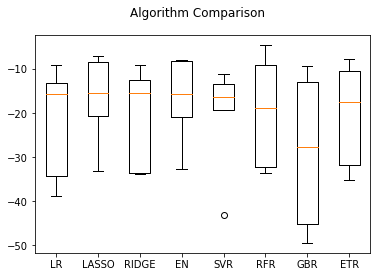

In [110]:
from matplotlib import pyplot

fig = pyplot.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
pyplot.boxplot(results)
ax.set_xticklabels(names)
pyplot.show()

So I decided to pursue the gradient boosting regression model. The next step is to consider feature decomposition (since I have a small dataset for eight features), and then to tune the hyperparameters. Therefore, two of the following pipelines include PCA (an easy option for continuous features). All of these pipelines are fed into cross-validation grid searches.

N.B. I made a mistake earlier in my analysis that suggested SVM may have had the best MSE. I've kept my code in this notebook to demonstrate another example of a grid search pipeline.

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA


In [0]:
est1 = [('reduce_dim', PCA()), ('svr', svm.SVR())]
pipe1 = Pipeline(steps=est1)
est2 = [('reduce_dim', PCA()), ('gbr', ensemble.GradientBoostingRegressor())]
pipe2 = Pipeline(steps=est2)
pipe3 = Pipeline(steps = [('gbr', ensemble.GradientBoostingRegressor())])

In [0]:
param_grid1 = dict(reduce_dim__n_components=[2,3,4,5], svr__C=[0.01, 0.1, 10, 100,1000], svr__gamma = [0.1,0.01])
param_grid2 = dict(reduce_dim__n_components=[2,3,4], gbr__n_estimators=[5,10,40,50,60,100], gbr__learning_rate = [0.1,0.05,0.02,0.01,0.005],gbr__max_depth=[1,2,3,4],gbr__min_samples_leaf=[1,2])
param_grid3 = dict(gbr__n_estimators=[2,5,10,25,50,100,200,500], gbr__learning_rate = [0.1,0.05,0.02,0.01,0.005],gbr__max_depth=[1,2,3,4],gbr__min_samples_split=[2,3],gbr__min_samples_leaf=[1,2])

In [0]:
from sklearn.model_selection import GridSearchCV
gs1 = GridSearchCV(pipe1, param_grid=param_grid1, cv=5)
gs2 = GridSearchCV(pipe2, param_grid=param_grid2, cv=5)
gs3 = GridSearchCV(pipe3, param_grid=param_grid3, cv=5)

In [106]:
gs3.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:813: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=Pipeline(memory=None,
                                steps=[('gbr',
                                        GradientBoostingRegressor(alpha=0.9,
                                                                  criterion='friedman_mse',
                                                                  init=None,
                                                                  learning_rate=0.1,
                                                                  loss='ls',
                                                                  max_depth=3,
                                                                  max_features=None,
                                                                  max_leaf_nodes=None,
                                                                  min_impurity_decrease=0.0,
                                                                  min_impurity_split=None,
             

In [107]:
gs3.best_params_

{'gbr__learning_rate': 0.1,
 'gbr__max_depth': 2,
 'gbr__min_samples_leaf': 2,
 'gbr__min_samples_split': 2,
 'gbr__n_estimators': 5}

In [111]:
gs3.score(X,y)

0.25784315428178284

After comparing **gs2** (pipeline beginning with PCA) with **gs3** (no PCA),  the higher coefficient of determination occurred without PCA. This may be because gradient boosting regression already considers the number of features, somewhat obviating the need for PCA. 

In [123]:
gs3.predict(X)

array([72.19784797, 74.21460327, 72.19784797, 73.75525195, 73.85886976,
       73.85886976, 73.85886976, 73.98515214, 72.42774816, 73.98515214,
       72.42774816, 72.19784797, 73.85886976, 73.98515214, 75.43368103,
       72.19784797, 72.42774816, 75.43368103, 76.00420008, 72.19784797,
       75.66313216, 75.66313216, 72.42774816, 73.85886976, 73.85886976,
       72.19784797, 72.19784797, 72.19784797, 74.21460327, 73.85886976,
       72.42774816, 72.42774816, 74.55567119, 72.19784797, 72.19784797,
       74.21460327, 75.43368103, 76.00420008, 72.19784797, 72.19784797,
       72.19784797, 72.19784797, 72.19784797, 72.42774816, 72.19784797,
       72.19784797, 72.19784797, 72.19784797, 72.19784797, 72.19784797,
       72.19784797, 72.19784797, 72.19784797, 73.85886976, 72.19784797,
       75.20378084, 72.42774816, 72.19784797, 74.21460327, 75.66313216,
       73.85886976, 72.19784797, 72.19784797, 72.19784797, 72.19784797,
       73.85886976, 73.85886976, 73.98515214, 72.19784797, 72.19

We can now plot the distribution of predicted life expectancies over the measured life expectancies.

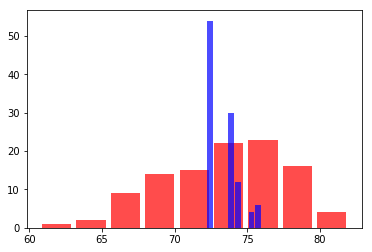

In [125]:
import matplotlib.pyplot as plt

n, bins, patches = plt.hist(x=df2['life'], bins='auto', color='red', alpha=0.7, rwidth=0.85)
#n, bins, patches = plt.hist(x=clf.predict(X), bins='auto', color='blue', alpha=0.7, rwidth=0.85)
#n, bins, patches = plt.hist(x=ridg.predict(X), bins='auto', color='green', alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=gs3.predict(X), bins='auto', color='blue', alpha=0.7, rwidth=0.85)

This is consistent with R^2 = 0.25. Not too impressive, but we can have some confidence that the model is not overfit or underfit.

For the fun of it, I also grossly overfit a model.

In [138]:
gbr = ensemble.GradientBoostingRegressor(n_estimators=100, learning_rate=0.05,max_depth=4)
gbr.fit(X_train,y_train)
gbr.score(X,y)

0.7700901306931786

Of course, this model fits the data very well.

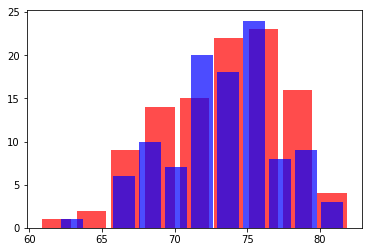

In [139]:
n, bins, patches = plt.hist(x=df2['life'], bins='auto', color='red', alpha=0.7, rwidth=0.85)
#n, bins, patches = plt.hist(x=clf.predict(X), bins='auto', color='blue', alpha=0.7, rwidth=0.85)
#n, bins, patches = plt.hist(x=ridg.predict(X), bins='auto', color='green', alpha=0.7, rwidth=0.85)
n, bins, patches = plt.hist(x=gbr.predict(X), bins='auto', color='blue', alpha=0.7, rwidth=0.85)

In [0]:
outp = gs3.predict(X)

In [0]:
df3 = df2
df3['outp'] = outp

In [142]:
df3.head()

,land_perc,food1,food2,life,mw,cg,metrolink,tract_area,bike_len,bike_cnt,park1,park2,park1ratio,park2ratio,walk,unins,outp
GEOID,,,,,,,,,,,,,,,,,
29510106400,1.000000,0.000000,0.000000,69.9,1,0,0,1106529.051,855.237401,2,0.000,0.000,0.000000,0.000000,14.041750,27.0,72.197848
29510125600,0.805083,0.000000,0.000000,73.2,3,0,4,2582190.793,12671.559820,25,39157.102,39157.102,0.015164,0.015164,18.777667,6.7,74.214603
29510125700,0.857948,0.000331,0.000261,72.0,0,2,0,1486619.951,2922.391749,8,25647.334,25647.334,0.017252,0.017252,16.444667,18.2,72.197848
29510123300,1.000000,0.453672,0.175716,76.2,0,0,0,918019.537,2305.878671,8,1650.961,1650.961,0.001798,0.001798,17.722000,8.7,73.755252
29510124100,1.000000,0.000000,0.000000,67.8,9,1,0,1053137.860,1853.596805,6,0.000,0.000,0.000000,0.000000,13.833400,18.8,73.858870


In [0]:
from google.colab import files
df3.to_csv('outp.csv') 
files.download('outp.csv')